### Data Preprocessing

In [1]:
import torch
import torchvision
import torchinfo
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from shutil import copy  # Import shutil for high-level file operations
from shutil import rmtree, copytree
from pathlib import Path
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from collections import defaultdict
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

c:\Users\PC\anaconda3\envs\torch_gpuenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

## Loading and organize the Images by Category

**1. Reading and Processing Data:**

- Reads image paths and class information from the text file of the dataset meta.
- Builds a dictionary mapping class names to lists of image filenames.

**2. Organizing Images:**

- Iterates through each class:
    - Creates a folder for the class if it doesn't exist.
    - Copies images belonging to the class into the corresponding folder.

In [2]:
def prepare_the_data(data_txt_path, src, dest):
    classes = defaultdict(list)
    # data_txt_path = 'D:/Downloads/food101/food-101/meta/train.txt'
    # src = 'D:/Downloads/food101/food-101/images'
    # #target = 'D:/Downloads/food101_split'
    # dest = 'train'
    with open(data_txt_path, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]

    for i in paths:
        class_with_img = i.split('/')
        classes[class_with_img[0]].append(class_with_img[1] + '.jpg')

    for food_class in classes.keys():
        print(f'Copying the {food_class} class.. ')
        if not os.path.exists(os.path.join(dest, food_class)):
            os.makedirs(os.path.join(dest, food_class))
        for i in classes[food_class]:
            copy(os.path.join(src, food_class, i), os.path.join(dest, food_class, i))
        print(f'{food_class} is copied !')

In [3]:
# Prepare the Train data
prepare_the_data('D:/Downloads/food101/food-101/meta/train.txt', 'D:/Downloads/food101/food-101/images', 'train')

Copying the apple_pie class.. 
apple_pie is copied !
Copying the baby_back_ribs class.. 
baby_back_ribs is copied !
Copying the baklava class.. 
baklava is copied !
Copying the beef_carpaccio class.. 
beef_carpaccio is copied !
Copying the beef_tartare class.. 
beef_tartare is copied !
Copying the beet_salad class.. 
beet_salad is copied !
Copying the beignets class.. 
beignets is copied !
Copying the bibimbap class.. 
bibimbap is copied !
Copying the bread_pudding class.. 
bread_pudding is copied !
Copying the breakfast_burrito class.. 
breakfast_burrito is copied !
Copying the bruschetta class.. 
bruschetta is copied !
Copying the caesar_salad class.. 
caesar_salad is copied !
Copying the cannoli class.. 
cannoli is copied !
Copying the caprese_salad class.. 
caprese_salad is copied !
Copying the carrot_cake class.. 
carrot_cake is copied !
Copying the ceviche class.. 
ceviche is copied !
Copying the cheesecake class.. 
cheesecake is copied !
Copying the cheese_plate class.. 
cheese_

In [4]:
# Prepare the test data
prepare_the_data('D:/Downloads/food101/food-101/meta/test.txt', 'D:/Downloads/food101/food-101/images', 'test')

Copying the apple_pie class.. 
apple_pie is copied !
Copying the baby_back_ribs class.. 
baby_back_ribs is copied !
Copying the baklava class.. 
baklava is copied !
Copying the beef_carpaccio class.. 
beef_carpaccio is copied !
Copying the beef_tartare class.. 
beef_tartare is copied !
Copying the beet_salad class.. 
beet_salad is copied !
Copying the beignets class.. 
beignets is copied !
Copying the bibimbap class.. 
bibimbap is copied !
Copying the bread_pudding class.. 
bread_pudding is copied !
Copying the breakfast_burrito class.. 
breakfast_burrito is copied !
Copying the bruschetta class.. 
bruschetta is copied !
Copying the caesar_salad class.. 
caesar_salad is copied !
Copying the cannoli class.. 
cannoli is copied !
Copying the caprese_salad class.. 
caprese_salad is copied !
Copying the carrot_cake class.. 
carrot_cake is copied !
Copying the ceviche class.. 
ceviche is copied !
Copying the cheesecake class.. 
cheesecake is copied !
Copying the cheese_plate class.. 
cheese_

## Grabbing a Random Image

1. **Sets image path:** Stores the dataset directory in `image_path`.
2. **Lists images:** Uses `glob` to find all `.jpg` files recursively, storing paths in `images_path_list`. It then prints the total image count.
3. **Selects randomly:** Chooses a random image path from the list using `random.choice`.
4. **Loads image:** Opens the chosen image using `Image.open` and assigns it to `img`.

This snippet efficiently retrieves a random image for further processing.

length of our dataset images(Train and Test): 3750


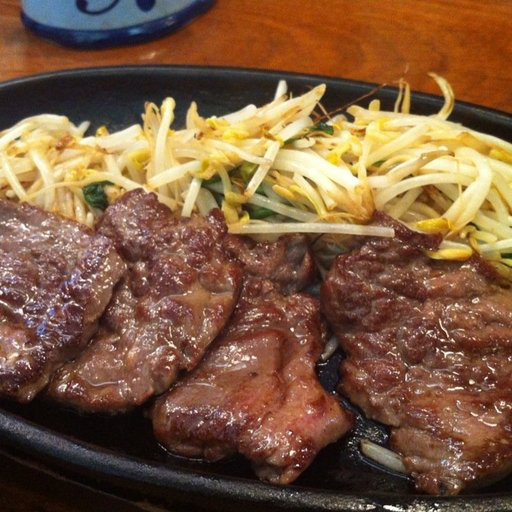

In [2]:
# Getting a random picture from our dataset
image_path = Path('D:/Downloads/food101_split/train_mini')
images_path_list = list(image_path.glob('*/*.jpg'))
print(f'length of our dataset images(Train and Test): {len(images_path_list)}')
random_img = random.choice(images_path_list)
img = Image.open(random_img)
img

In [2]:
os.chdir('D:/Downloads/food101_split')

In [17]:
# Define the train and test directories
train_dir = 'D:/Downloads/food101_split/train_mini'
test_dir = 'D:/Downloads/food101_split/test_mini'
image_path_list = list(Path('D:/Downloads/food101_split/train_mini').glob('*/*.jpg'))

## Creating a Mini Dataset

The `dataset_mini` function creates a smaller dataset from a larger one, focusing on specific items:

1. **Clean slate:** Checks and removes the destination directory if it exists, then creates it.
2. **Selective copying:** Iterates through each food item in the list:
    - Prints a message indicating the processing item.
    - Copies the entire directory structure (files and subfolders) for the item from source to destination.

In [5]:
def dataset_mini(food_list, src, dest):
    # Check if the destination directory exists
    if os.path.exists(dest):
        # If it exists, remove it to ensure a clean slate
        rmtree(dest)  # Removing dataset_mini (if it already exists) folders
    # Create the destination directory
    os.makedirs(dest)
    
    # Iterate over each food item in the provided list
    for food_item in food_list:
        print("Copying images into", food_item)
        # Recursively copy the images from the source directory to the destination directory for each food item
        copytree(os.path.join(src, food_item), os.path.join(dest, food_item))

In [6]:
# Choosing 5 classes from the dataset(101 classes)
food_list = ['donuts', 'pizza', 'hamburger', 'steak', 'sushi']

# Source and destination directories for train and test datasets
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

# Create train_mini dataset
dataset_mini(food_list, src_train, dest_train)

# Create test_mini dataset
dataset_mini(food_list, src_test, dest_test)

Copying images into donuts
Copying images into pizza
Copying images into hamburger
Copying images into steak
Copying images into sushi
Copying images into donuts
Copying images into pizza
Copying images into hamburger
Copying images into steak
Copying images into sushi


## Data Transformations

- Separate transformations applied for training (with random augmentation) and testing (simpler for fair evaluation).
- Training transformations (using `RandomOrder`):
    - `RandAugment`: injects variability through random color, spatial, and other distortions.
    - `TrivialAugmentWide`: basic flips and color jittering for further diversity.
- All images resized and converted to PyTorch tensors.
- Normalization improves training stability by centering and scaling pixel values.


In [23]:
# Transform the train and test data
train_transforms_augmented = transforms.Compose([
    transforms.RandomOrder((
        transforms.RandAugment(),
        transforms.TrivialAugmentWide()
    )),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms_simple = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


## Creating Datasets

Prepares datasets for training and testing:

1. **Concatenated Training Dataset:**
    - Combines two `ImageFolder` datasets using `ConcatDataset`.
    - One dataset uses `train_transforms_augmented` for data augmentation during training.
    - The other uses `test_transforms_simple` without augmentation.
2. **Testing Dataset:**
    - Creates an `ImageFolder` dataset for testing data using `test_transforms_simple`.
    - Disables target transformation (`target_transform=None`) as labels might not be needed for testing.

In [24]:
train_concated_dataset = torch.utils.data.ConcatDataset(
                                        datasets=[
                                        datasets.ImageFolder(train_dir,
                                        transform = train_transforms_augmented),
                                        datasets.ImageFolder(train_dir,
                                        transform = test_transforms_simple)])

test_data_folder = datasets.ImageFolder(test_dir,
                                        transform=test_transforms_simple,
                                        target_transform=None)


## Visualizing Transformed Images

**Function:**

- Randomly selects `n` images.
- Iterates, displaying original and transformed versions in a 2-subplot figure:
    - Original: displayed with size info, axes hidden.
    - Transformed: applied with `transform`, displayed with size info, axes hidden.
- Adds image class as a supertitle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


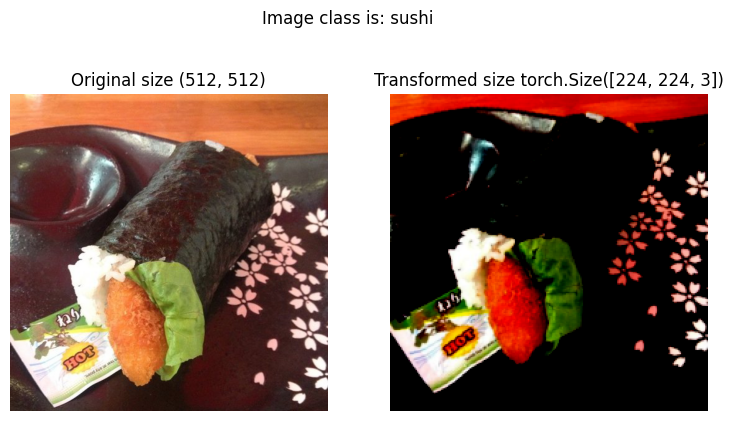

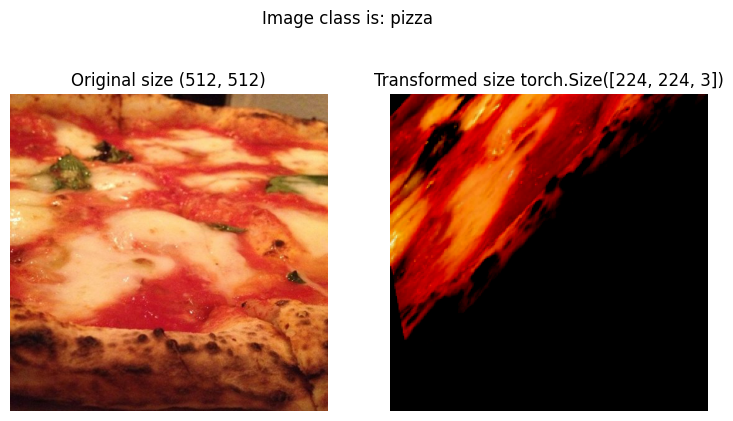

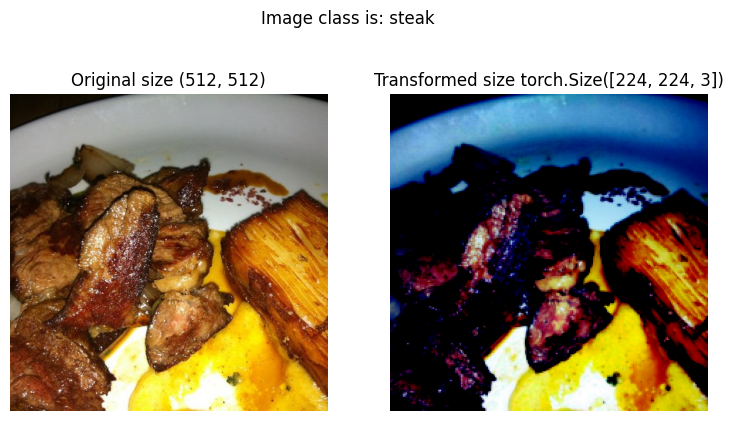

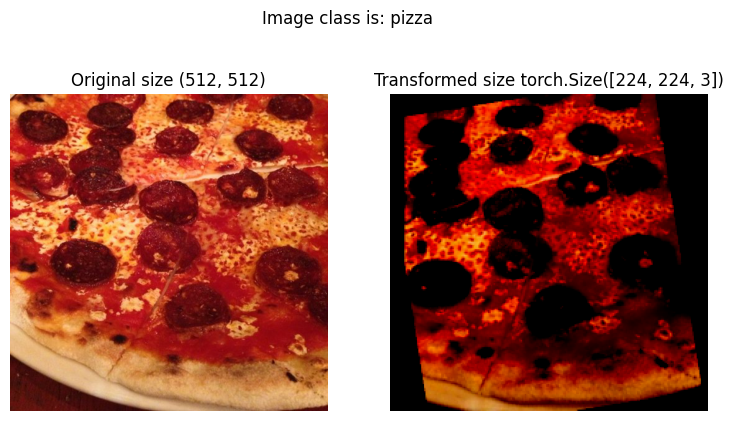

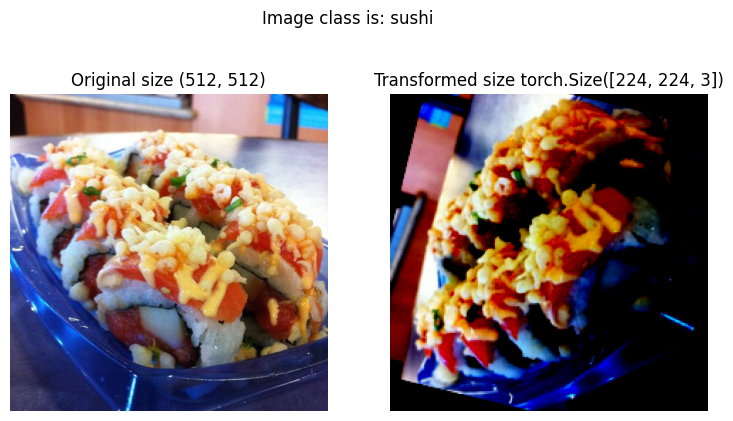

In [28]:
def plot_transformed_img(image_paths, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    random_img_paths = random.sample(image_paths, k=n)
    for image_path in random_img_paths:
        with Image.open(image_path, 'r') as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original size {f.size}')
            ax[0].axis(False);

            transformed_img = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_img)
            ax[1].set_title(f'Transformed size {transformed_img.shape}')
            ax[1].axis(False)
        fig.set_figheight(val=5)
        fig.set_figwidth(val=9)
        fig.suptitle(f"Image class is: {image_path.parent.stem}", fontsize=12, fontweight='normal')

plot_transformed_img(image_path_list, train_transforms_augmented, n=5)



Sets up `Dataloaders` for training and testing using PyTorch:

- **Batching:** `BATCH_SIZE` images are processed together (16 here) for efficiency.
- **Parallelism:** `NUM_WORKERS` CPU cores load data concurrently (utilizes all cores).
- **Shuffling:** Training data is shuffled for better generalization.
- **Class Information:** Class names (`data_classes`) and their corresponding indices (`classes_to_idx`) are stored.

Dataloaders streamline data loading, improving training and testing efficiency.


In [29]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(train_concated_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data_folder,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS)

In [30]:
# Checking the shape of the train data
train_img, train_label = next(iter(train_dataloader))
train_img.shape, train_label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [31]:
# Checking the number of bathces of each dataset (train and test)
len(train_dataloader), len(test_dataloader)

(235, 40)

In [32]:
data_classes = test_data_folder.classes
classes_to_idx = test_data_folder.class_to_idx
data_classes, classes_to_idx

(['donuts', 'hamburger', 'pizza', 'steak', 'sushi'],
 {'donuts': 0, 'hamburger': 1, 'pizza': 2, 'steak': 3, 'sushi': 4})

# Model Initialization

<img src='/images/resnet.png'>

## Building a ResNet50 Model

**1. Bottleneck Block Definition:**

- The `Bottleneck` class defines a residual building block used in ResNet.
- It takes input and output channels, an optional downsampling operation, and stride as arguments during initialization.
- The block consists of three convolutional layers with batch normalization and ReLU activation in between.
- The expansion parameter controls the number of channels after the final convolution (default: 4x input channels).
- A residual connection is added if the input and output channels differ or downsampling is applied.

**2. ResNet Model Definition:**

- The `ResNet` class defines the overall ResNet architecture.
- It takes the residual block class, a list specifying the number of blocks per stage, number of classes, and input channels as arguments during initialization.
- It starts with a convolutional layer, batch normalization, ReLU activation, and a max-pooling layer.
- Four residual stages are created using the `_make_layer` function, each with a specific number of blocks and potentially increasing the number of channels.
- After the stages, global average pooling is applied, followed by a fully connected layer for classification.
- The `_make_layer` function creates a sequential block of residual blocks based on the provided arguments.
- It handles downsampling the input channels if necessary to match the output of the residual block.

**3. Building a ResNet50 Model:**

- The `ResNet50` function creates a ResNet model with the `Bottleneck` block and a specific configuration for 101 residual blocks.

**4. Model Instantiation:**

- Finally, a `ResNet50` model is created with the number of classes from `data_classes` and transferred to the specified device (e.g., GPU).


<img src='/images/d99c424a498df105b154858f35f523f35ee74aea154f6a0a5d957d4a4d1395f7.png'>

In [33]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x       
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

        
        
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

model = ResNet50(len(data_classes)).to(device)

## Loss Function, Optimizer & Scheduler

- The `nn.CrossEntropyLoss` calculates the loss for multi-class classification.
- The Adam optimizer updates model parameters based on the loss with a learning rate of 0.0003.


In [34]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params= model.parameters(), lr=3e-4, betas=[0.9, 0.999])

# Train the model

 **Training and Testing in PyTorch**

- **`train_step`:**
    - Trains model on a data batch.
    - Forward pass, loss calculation, backpropagation, parameter updates.
    - Tracks and returns average loss and accuracy.

- **`test_step`:**
    - Evaluates model on a data batch.
    - Forward pass, loss calculation, accuracy calculation.
    - No backpropagation, uses inference mode.
    - Tracks and returns average loss and accuracy.


In [35]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        
        # 5. Optimizer step
        optimizer.step()
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        # if batch % 50 == 0 or batch == len(train_dataloader):
        #     print(f'{batch*BATCH_SIZE} / {len(train_dataloader) * BATCH_SIZE}')
    
    # scheduler.step()

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [36]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## Custom Callback: Save Best Model

This code defines a `SaveBestModel` callback that saves the best performing model during training:

* Tracks the best validation loss and a waiting period.
* Saves the model, optimizer state, and epoch/test accuracy when a better validation loss is found (after waiting period).

This helps access the best model based on validation performance.

In [37]:
class SaveBestModel:
    def __init__(self, best_validation_loss = float('inf')):
        self.best_validation_loss = best_validation_loss
        self.EPOCH_PATIENCE = 20
    def __call__(self, current_validation_loss, current_test_acc, model, epoch, optimizer):
        if current_validation_loss < self.best_validation_loss and epoch > self.EPOCH_PATIENCE:
            # Prinitng the new loss
            print(f'Found new best test loss: {current_validation_loss} ...')
            self.best_validation_loss = current_validation_loss

            # Saving the model
            print(f'Saving the model... ')
            torch.save({
                'epoch' : epoch+1,
                'model_stat_dict' : model.state_dict(),
                'optimizer' : optimizer.state_dict()
            }, f'D:/Downloads/food101_split/trained_model/model{int(np.round((current_test_acc / 1) * 100))}.pth')
    
save_best_model = SaveBestModel()

## Early Stopping for Overfitting Prevention

This code implements `ValidationLossEarlyStopping` to prevent overfitting:

- **Initialization:** Sets parameters for patience (default 50 epochs) and minimum improvement threshold (default 0.0) for validation loss.

- **`early_stop_check`:** Tracks the best validation loss and a counter for non-improvement. Stops training if validation loss doesn't improve by the minimum threshold for the specified patience.

This technique helps prevent overfitting by stopping training when the model stops improving on the validation set.


In [38]:
class ValidationLossEarlyStopping:
    def __init__(self, patience=50):
        self.patience = patience  # number of times to allow for no improvement before stopping the execution
        self.counter = 0  # count the number of times the validation accuracy not improving
        self.min_validation_loss = np.inf
        self.early_stop = True

    # return True when validation loss is not decreased by the `min_delta` for `patience` times 
    def early_stop_check(self, validation_loss):
        if ((validation_loss) < self.min_validation_loss):
            self.min_validation_loss = validation_loss
            self.counter = 0  # reset the counter if validation loss decreased
        elif ((validation_loss) >= self.min_validation_loss):
            self.counter += 1 # increase the counter if validation loss is not decreased
            if self.counter > self.patience:
                self.early_stop = False
            else:
                self.early_stop = True

early_stop = ValidationLossEarlyStopping()

In [39]:
# 1. Take in various parameters required for training and test steps
lrs = []
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening

        print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f}"
        )

        # Checking the current test loss and save the model if it the best
        save_best_model(test_loss, test_acc, model, epoch, optimizer)

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # Checking if there is no improvments for the last 50 epochs
        early_stop.early_stop_check(test_loss)

        if not early_stop.early_stop:
            print(f'No improvments for 50 epochs')
            break

        # adjusting the learning rate by the scheduler
        # lrs.append(optimizer.param_groups[0]["lr"])
        # print(lrs)
        # scheduler.step()

    # 6. Return the filled results at the end of the epochs
    return results

In [40]:
model_results = train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=300)

  0%|          | 1/300 [01:52<9:18:29, 112.07s/it]

Epoch: 1 | train_loss: 1.5381 | train_acc: 0.3600 | test_loss: 1.2790 | test_acc: 0.4789


  1%|          | 2/300 [03:38<8:59:43, 108.67s/it]

Epoch: 2 | train_loss: 1.3362 | train_acc: 0.4639 | test_loss: 1.1494 | test_acc: 0.5469


  1%|          | 3/300 [05:25<8:53:29, 107.77s/it]

Epoch: 3 | train_loss: 1.2276 | train_acc: 0.5184 | test_loss: 0.9406 | test_acc: 0.6789


  1%|▏         | 4/300 [07:10<8:46:15, 106.67s/it]

Epoch: 4 | train_loss: 1.1452 | train_acc: 0.5562 | test_loss: 1.1270 | test_acc: 0.5695


  2%|▏         | 5/300 [08:52<8:37:30, 105.25s/it]

Epoch: 5 | train_loss: 1.0403 | train_acc: 0.6039 | test_loss: 1.8890 | test_acc: 0.6086


  2%|▏         | 6/300 [10:35<8:31:27, 104.38s/it]

Epoch: 6 | train_loss: 0.9710 | train_acc: 0.6383 | test_loss: 1.2643 | test_acc: 0.5813


  2%|▏         | 7/300 [12:18<8:27:05, 103.84s/it]

Epoch: 7 | train_loss: 0.8974 | train_acc: 0.6655 | test_loss: 1.1510 | test_acc: 0.6094


  3%|▎         | 8/300 [14:00<8:23:30, 103.46s/it]

Epoch: 8 | train_loss: 0.8593 | train_acc: 0.6850 | test_loss: 0.8304 | test_acc: 0.7070


  3%|▎         | 9/300 [15:43<8:20:23, 103.17s/it]

Epoch: 9 | train_loss: 0.7971 | train_acc: 0.7062 | test_loss: 0.9037 | test_acc: 0.6922


  3%|▎         | 10/300 [17:25<8:17:41, 102.97s/it]

Epoch: 10 | train_loss: 0.7382 | train_acc: 0.7255 | test_loss: 1.0836 | test_acc: 0.6500


  4%|▎         | 11/300 [19:08<8:15:40, 102.91s/it]

Epoch: 11 | train_loss: 0.6850 | train_acc: 0.7549 | test_loss: 0.8152 | test_acc: 0.7070


  4%|▍         | 12/300 [20:51<8:13:48, 102.88s/it]

Epoch: 12 | train_loss: 0.6539 | train_acc: 0.7556 | test_loss: 0.8084 | test_acc: 0.7352


  4%|▍         | 13/300 [22:34<8:11:47, 102.81s/it]

Epoch: 13 | train_loss: 0.5898 | train_acc: 0.7889 | test_loss: 0.7277 | test_acc: 0.7602


  5%|▍         | 14/300 [24:16<8:09:35, 102.71s/it]

Epoch: 14 | train_loss: 0.5487 | train_acc: 0.7978 | test_loss: 0.7116 | test_acc: 0.7703


  5%|▌         | 15/300 [25:59<8:07:32, 102.64s/it]

Epoch: 15 | train_loss: 0.5199 | train_acc: 0.8119 | test_loss: 1.2611 | test_acc: 0.6766


  5%|▌         | 16/300 [27:41<8:05:58, 102.67s/it]

Epoch: 16 | train_loss: 0.4966 | train_acc: 0.8180 | test_loss: 0.6628 | test_acc: 0.7898


  6%|▌         | 17/300 [29:24<8:04:08, 102.64s/it]

Epoch: 17 | train_loss: 0.4602 | train_acc: 0.8316 | test_loss: 0.6397 | test_acc: 0.8031


  6%|▌         | 18/300 [31:07<8:02:27, 102.65s/it]

Epoch: 18 | train_loss: 0.4446 | train_acc: 0.8428 | test_loss: 0.7612 | test_acc: 0.7586


  6%|▋         | 19/300 [32:49<8:00:43, 102.64s/it]

Epoch: 19 | train_loss: 0.4127 | train_acc: 0.8485 | test_loss: 0.5507 | test_acc: 0.8125


  7%|▋         | 20/300 [34:32<7:58:49, 102.60s/it]

Epoch: 20 | train_loss: 0.4071 | train_acc: 0.8533 | test_loss: 0.7139 | test_acc: 0.7992


  7%|▋         | 21/300 [36:15<7:57:29, 102.68s/it]

Epoch: 21 | train_loss: 0.3913 | train_acc: 0.8641 | test_loss: 0.6160 | test_acc: 0.8031
Epoch: 22 | train_loss: 0.3704 | train_acc: 0.8660 | test_loss: 0.6500 | test_acc: 0.8008
Found new best test loss: 0.6500016100122593 ...
Saving the model... 


  7%|▋         | 22/300 [37:58<7:56:35, 102.86s/it]

Epoch: 23 | train_loss: 0.3498 | train_acc: 0.8740 | test_loss: 0.6336 | test_acc: 0.8063
Found new best test loss: 0.6335890270769596 ...
Saving the model... 


  8%|▊         | 24/300 [41:31<8:02:14, 104.83s/it]

Epoch: 24 | train_loss: 0.3471 | train_acc: 0.8801 | test_loss: 0.9471 | test_acc: 0.7477
Epoch: 25 | train_loss: 0.3560 | train_acc: 0.8760 | test_loss: 0.5486 | test_acc: 0.8227
Found new best test loss: 0.5485567873693071 ...
Saving the model... 


  9%|▊         | 26/300 [45:05<8:03:00, 105.77s/it]

Epoch: 26 | train_loss: 0.3178 | train_acc: 0.8925 | test_loss: 0.8791 | test_acc: 0.7586


  9%|▉         | 27/300 [46:51<8:02:18, 106.00s/it]

Epoch: 27 | train_loss: 0.3327 | train_acc: 0.8837 | test_loss: 0.6691 | test_acc: 0.7766


  9%|▉         | 28/300 [48:38<8:01:08, 106.14s/it]

Epoch: 28 | train_loss: 0.3319 | train_acc: 0.8800 | test_loss: 0.9154 | test_acc: 0.7688


 10%|▉         | 29/300 [50:25<8:00:17, 106.34s/it]

Epoch: 29 | train_loss: 0.3461 | train_acc: 0.8791 | test_loss: 0.6330 | test_acc: 0.8063


 10%|█         | 30/300 [52:11<7:58:20, 106.30s/it]

Epoch: 30 | train_loss: 0.3058 | train_acc: 0.8946 | test_loss: 0.6298 | test_acc: 0.8000


 10%|█         | 31/300 [53:57<7:56:08, 106.20s/it]

Epoch: 31 | train_loss: 0.3013 | train_acc: 0.8930 | test_loss: 0.6813 | test_acc: 0.8172


 11%|█         | 32/300 [55:43<7:54:00, 106.12s/it]

Epoch: 32 | train_loss: 0.2874 | train_acc: 0.8975 | test_loss: 0.7036 | test_acc: 0.8094


 11%|█         | 33/300 [57:29<7:52:10, 106.11s/it]

Epoch: 33 | train_loss: 0.2683 | train_acc: 0.9063 | test_loss: 0.9127 | test_acc: 0.7281
Epoch: 34 | train_loss: 0.2972 | train_acc: 0.8960 | test_loss: 0.5251 | test_acc: 0.8391
Found new best test loss: 0.5250601758132689 ...
Saving the model... 


 12%|█▏        | 35/300 [1:01:02<7:49:20, 106.27s/it]

Epoch: 35 | train_loss: 0.2723 | train_acc: 0.9062 | test_loss: 0.5474 | test_acc: 0.8297


 12%|█▏        | 36/300 [1:02:47<7:46:34, 106.04s/it]

Epoch: 36 | train_loss: 0.2767 | train_acc: 0.9012 | test_loss: 0.7154 | test_acc: 0.7898


 12%|█▏        | 37/300 [1:04:32<7:43:03, 105.64s/it]

Epoch: 37 | train_loss: 0.2803 | train_acc: 0.9039 | test_loss: 0.8825 | test_acc: 0.7820


 13%|█▎        | 38/300 [1:06:18<7:41:23, 105.66s/it]

Epoch: 38 | train_loss: 0.2592 | train_acc: 0.9089 | test_loss: 0.6385 | test_acc: 0.8273


 13%|█▎        | 39/300 [1:08:03<7:38:58, 105.51s/it]

Epoch: 39 | train_loss: 0.2784 | train_acc: 0.9037 | test_loss: 0.5284 | test_acc: 0.8422


 13%|█▎        | 40/300 [1:09:49<7:38:02, 105.70s/it]

Epoch: 40 | train_loss: 0.2586 | train_acc: 0.9131 | test_loss: 0.6317 | test_acc: 0.8180


 14%|█▎        | 41/300 [1:11:35<7:37:03, 105.88s/it]

Epoch: 41 | train_loss: 0.2579 | train_acc: 0.9099 | test_loss: 0.7368 | test_acc: 0.7891


 14%|█▍        | 42/300 [1:13:19<7:32:40, 105.27s/it]

Epoch: 42 | train_loss: 0.2603 | train_acc: 0.9060 | test_loss: 0.5364 | test_acc: 0.8352


 14%|█▍        | 43/300 [1:15:05<7:31:47, 105.48s/it]

Epoch: 43 | train_loss: 0.2571 | train_acc: 0.9101 | test_loss: 0.6252 | test_acc: 0.8242


 15%|█▍        | 44/300 [1:16:51<7:30:50, 105.67s/it]

Epoch: 44 | train_loss: 0.2333 | train_acc: 0.9183 | test_loss: 0.6279 | test_acc: 0.8172


 15%|█▌        | 45/300 [1:18:37<7:29:37, 105.80s/it]

Epoch: 45 | train_loss: 0.2314 | train_acc: 0.9181 | test_loss: 0.6834 | test_acc: 0.8133


 15%|█▌        | 46/300 [1:20:24<7:28:35, 105.97s/it]

Epoch: 46 | train_loss: 0.2416 | train_acc: 0.9149 | test_loss: 0.6143 | test_acc: 0.8219


 16%|█▌        | 47/300 [1:22:10<7:27:14, 106.07s/it]

Epoch: 47 | train_loss: 0.2468 | train_acc: 0.9116 | test_loss: 0.7522 | test_acc: 0.7844


 16%|█▌        | 48/300 [1:23:56<7:25:33, 106.09s/it]

Epoch: 48 | train_loss: 0.2151 | train_acc: 0.9233 | test_loss: 0.6549 | test_acc: 0.8164


 16%|█▋        | 49/300 [1:25:42<7:23:49, 106.09s/it]

Epoch: 49 | train_loss: 0.2158 | train_acc: 0.9256 | test_loss: 0.5971 | test_acc: 0.8406
Epoch: 50 | train_loss: 0.2240 | train_acc: 0.9215 | test_loss: 0.5026 | test_acc: 0.8500
Found new best test loss: 0.5026085410849191 ...
Saving the model... 


 17%|█▋        | 51/300 [1:29:15<7:20:58, 106.26s/it]

Epoch: 51 | train_loss: 0.2208 | train_acc: 0.9225 | test_loss: 0.9296 | test_acc: 0.7812


 17%|█▋        | 52/300 [1:31:01<7:18:16, 106.03s/it]

Epoch: 52 | train_loss: 0.2423 | train_acc: 0.9174 | test_loss: 0.6634 | test_acc: 0.8039
Epoch: 53 | train_loss: 0.2231 | train_acc: 0.9250 | test_loss: 0.4670 | test_acc: 0.8625
Found new best test loss: 0.467040094838012 ...
Saving the model... 


 18%|█▊        | 54/300 [1:34:32<7:14:28, 105.97s/it]

Epoch: 54 | train_loss: 0.2144 | train_acc: 0.9234 | test_loss: 0.5831 | test_acc: 0.8086


 18%|█▊        | 55/300 [1:36:19<7:13:53, 106.26s/it]

Epoch: 55 | train_loss: 0.2158 | train_acc: 0.9240 | test_loss: 0.5334 | test_acc: 0.8469


 19%|█▊        | 56/300 [1:38:06<7:12:11, 106.28s/it]

Epoch: 56 | train_loss: 0.2142 | train_acc: 0.9223 | test_loss: 0.5782 | test_acc: 0.8266


 19%|█▉        | 57/300 [1:39:52<7:10:14, 106.23s/it]

Epoch: 57 | train_loss: 0.2037 | train_acc: 0.9276 | test_loss: 0.5506 | test_acc: 0.8336


 19%|█▉        | 58/300 [1:41:38<7:08:32, 106.25s/it]

Epoch: 58 | train_loss: 0.2059 | train_acc: 0.9276 | test_loss: 0.5530 | test_acc: 0.8445


 20%|█▉        | 59/300 [1:43:24<7:05:54, 106.03s/it]

Epoch: 59 | train_loss: 0.2065 | train_acc: 0.9294 | test_loss: 0.5763 | test_acc: 0.8180


 20%|██        | 60/300 [1:45:10<7:04:30, 106.13s/it]

Epoch: 60 | train_loss: 0.1976 | train_acc: 0.9294 | test_loss: 0.6357 | test_acc: 0.8250


 20%|██        | 61/300 [1:46:56<7:02:45, 106.13s/it]

Epoch: 61 | train_loss: 0.2166 | train_acc: 0.9227 | test_loss: 0.6019 | test_acc: 0.8203


 21%|██        | 62/300 [1:48:39<6:57:37, 105.28s/it]

Epoch: 62 | train_loss: 0.2001 | train_acc: 0.9309 | test_loss: 0.9231 | test_acc: 0.7812


 21%|██        | 63/300 [1:50:26<6:56:50, 105.53s/it]

Epoch: 63 | train_loss: 0.1960 | train_acc: 0.9344 | test_loss: 0.7781 | test_acc: 0.8047


 21%|██▏       | 64/300 [1:52:09<6:52:28, 104.87s/it]

Epoch: 64 | train_loss: 0.2056 | train_acc: 0.9284 | test_loss: 0.7518 | test_acc: 0.8141


 22%|██▏       | 65/300 [1:53:52<6:48:10, 104.22s/it]

Epoch: 65 | train_loss: 0.1920 | train_acc: 0.9320 | test_loss: 0.6622 | test_acc: 0.8297


 22%|██▏       | 66/300 [1:55:34<6:44:37, 103.75s/it]

Epoch: 66 | train_loss: 0.1771 | train_acc: 0.9383 | test_loss: 0.5412 | test_acc: 0.8555


 22%|██▏       | 67/300 [1:57:17<6:41:40, 103.44s/it]

Epoch: 67 | train_loss: 0.1987 | train_acc: 0.9303 | test_loss: 0.6135 | test_acc: 0.8406


 23%|██▎       | 68/300 [1:58:59<6:38:52, 103.16s/it]

Epoch: 68 | train_loss: 0.1856 | train_acc: 0.9314 | test_loss: 0.5391 | test_acc: 0.8500


 23%|██▎       | 69/300 [2:00:42<6:36:53, 103.09s/it]

Epoch: 69 | train_loss: 0.1879 | train_acc: 0.9345 | test_loss: 0.7574 | test_acc: 0.7930


 23%|██▎       | 70/300 [2:02:25<6:34:59, 103.04s/it]

Epoch: 70 | train_loss: 0.1787 | train_acc: 0.9354 | test_loss: 0.5726 | test_acc: 0.8461


 24%|██▎       | 71/300 [2:04:08<6:33:02, 102.98s/it]

Epoch: 71 | train_loss: 0.1953 | train_acc: 0.9313 | test_loss: 0.8441 | test_acc: 0.7789


 24%|██▍       | 72/300 [2:05:51<6:31:00, 102.90s/it]

Epoch: 72 | train_loss: 0.1747 | train_acc: 0.9405 | test_loss: 0.6379 | test_acc: 0.8242


 24%|██▍       | 73/300 [2:07:33<6:28:52, 102.79s/it]

Epoch: 73 | train_loss: 0.1865 | train_acc: 0.9372 | test_loss: 0.5244 | test_acc: 0.8352


 25%|██▍       | 74/300 [2:09:16<6:27:15, 102.81s/it]

Epoch: 74 | train_loss: 0.1687 | train_acc: 0.9409 | test_loss: 1.0186 | test_acc: 0.8313


 25%|██▌       | 75/300 [2:10:59<6:25:25, 102.78s/it]

Epoch: 75 | train_loss: 0.1969 | train_acc: 0.9311 | test_loss: 0.4832 | test_acc: 0.8719


 25%|██▌       | 76/300 [2:12:42<6:23:35, 102.75s/it]

Epoch: 76 | train_loss: 0.1723 | train_acc: 0.9394 | test_loss: 0.5540 | test_acc: 0.8547


 26%|██▌       | 77/300 [2:14:24<6:21:47, 102.72s/it]

Epoch: 77 | train_loss: 0.1802 | train_acc: 0.9368 | test_loss: 0.6955 | test_acc: 0.8125


 26%|██▌       | 78/300 [2:16:07<6:20:03, 102.72s/it]

Epoch: 78 | train_loss: 0.1782 | train_acc: 0.9391 | test_loss: 0.4701 | test_acc: 0.8633


 26%|██▋       | 79/300 [2:17:50<6:18:21, 102.72s/it]

Epoch: 79 | train_loss: 0.1690 | train_acc: 0.9402 | test_loss: 0.5858 | test_acc: 0.8508


 27%|██▋       | 80/300 [2:19:32<6:16:25, 102.66s/it]

Epoch: 80 | train_loss: 0.1586 | train_acc: 0.9435 | test_loss: 0.5153 | test_acc: 0.8594
Epoch: 81 | train_loss: 0.1691 | train_acc: 0.9401 | test_loss: 0.4670 | test_acc: 0.8477
Found new best test loss: 0.46701013767160476 ...
Saving the model... 


 27%|██▋       | 82/300 [2:22:58<6:13:14, 102.73s/it]

Epoch: 82 | train_loss: 0.1745 | train_acc: 0.9396 | test_loss: 0.6286 | test_acc: 0.8391


 28%|██▊       | 83/300 [2:24:41<6:11:39, 102.76s/it]

Epoch: 83 | train_loss: 0.1614 | train_acc: 0.9437 | test_loss: 0.5669 | test_acc: 0.8367


 28%|██▊       | 84/300 [2:26:24<6:10:03, 102.80s/it]

Epoch: 84 | train_loss: 0.1662 | train_acc: 0.9423 | test_loss: 0.5262 | test_acc: 0.8578


 28%|██▊       | 85/300 [2:28:06<6:08:15, 102.77s/it]

Epoch: 85 | train_loss: 0.1716 | train_acc: 0.9414 | test_loss: 0.6142 | test_acc: 0.8422


 29%|██▊       | 86/300 [2:29:49<6:06:14, 102.69s/it]

Epoch: 86 | train_loss: 0.1532 | train_acc: 0.9445 | test_loss: 0.4809 | test_acc: 0.8688


 29%|██▉       | 87/300 [2:31:32<6:04:31, 102.68s/it]

Epoch: 87 | train_loss: 0.1492 | train_acc: 0.9487 | test_loss: 0.5070 | test_acc: 0.8633


 29%|██▉       | 88/300 [2:33:14<6:02:53, 102.71s/it]

Epoch: 88 | train_loss: 0.1616 | train_acc: 0.9433 | test_loss: 0.6584 | test_acc: 0.8305


 30%|██▉       | 89/300 [2:34:57<6:01:10, 102.70s/it]

Epoch: 89 | train_loss: 0.1587 | train_acc: 0.9441 | test_loss: 0.5495 | test_acc: 0.8477


 30%|███       | 90/300 [2:36:40<5:59:26, 102.70s/it]

Epoch: 90 | train_loss: 0.1566 | train_acc: 0.9452 | test_loss: 0.5577 | test_acc: 0.8492


 30%|███       | 91/300 [2:38:22<5:57:43, 102.70s/it]

Epoch: 91 | train_loss: 0.1539 | train_acc: 0.9436 | test_loss: 0.5693 | test_acc: 0.8633


 31%|███       | 92/300 [2:40:05<5:56:11, 102.75s/it]

Epoch: 92 | train_loss: 0.1427 | train_acc: 0.9523 | test_loss: 0.5729 | test_acc: 0.8375


 31%|███       | 93/300 [2:41:48<5:54:13, 102.67s/it]

Epoch: 93 | train_loss: 0.1566 | train_acc: 0.9447 | test_loss: 0.5884 | test_acc: 0.8414
Epoch: 94 | train_loss: 0.1491 | train_acc: 0.9469 | test_loss: 0.4384 | test_acc: 0.8844
Found new best test loss: 0.4383674512850121 ...
Saving the model... 


 32%|███▏      | 95/300 [2:45:13<5:50:48, 102.68s/it]

Epoch: 95 | train_loss: 0.1555 | train_acc: 0.9434 | test_loss: 0.4535 | test_acc: 0.8664


 32%|███▏      | 96/300 [2:46:56<5:48:55, 102.62s/it]

Epoch: 96 | train_loss: 0.1457 | train_acc: 0.9498 | test_loss: 0.5054 | test_acc: 0.8586


 32%|███▏      | 97/300 [2:48:38<5:47:04, 102.58s/it]

Epoch: 97 | train_loss: 0.1593 | train_acc: 0.9473 | test_loss: 0.4986 | test_acc: 0.8469


 33%|███▎      | 98/300 [2:50:21<5:45:37, 102.66s/it]

Epoch: 98 | train_loss: 0.1449 | train_acc: 0.9488 | test_loss: 0.5337 | test_acc: 0.8406


 33%|███▎      | 99/300 [2:52:04<5:44:10, 102.74s/it]

Epoch: 99 | train_loss: 0.1391 | train_acc: 0.9519 | test_loss: 0.5233 | test_acc: 0.8633


 33%|███▎      | 100/300 [2:53:47<5:42:27, 102.74s/it]

Epoch: 100 | train_loss: 0.1510 | train_acc: 0.9484 | test_loss: 0.5055 | test_acc: 0.8688


 34%|███▎      | 101/300 [2:55:29<5:40:30, 102.66s/it]

Epoch: 101 | train_loss: 0.1412 | train_acc: 0.9520 | test_loss: 0.5068 | test_acc: 0.8633


 34%|███▍      | 102/300 [2:57:12<5:39:02, 102.74s/it]

Epoch: 102 | train_loss: 0.1397 | train_acc: 0.9529 | test_loss: 0.8641 | test_acc: 0.8063


 34%|███▍      | 103/300 [2:58:55<5:37:26, 102.77s/it]

Epoch: 103 | train_loss: 0.1566 | train_acc: 0.9458 | test_loss: 0.4753 | test_acc: 0.8758


 35%|███▍      | 104/300 [3:00:37<5:35:29, 102.70s/it]

Epoch: 104 | train_loss: 0.1526 | train_acc: 0.9477 | test_loss: 0.4818 | test_acc: 0.8586


 35%|███▌      | 105/300 [3:02:20<5:33:45, 102.69s/it]

Epoch: 105 | train_loss: 0.1288 | train_acc: 0.9552 | test_loss: 0.4471 | test_acc: 0.8695


 35%|███▌      | 106/300 [3:04:03<5:32:01, 102.69s/it]

Epoch: 106 | train_loss: 0.1367 | train_acc: 0.9504 | test_loss: 0.4822 | test_acc: 0.8680
Epoch: 107 | train_loss: 0.1393 | train_acc: 0.9517 | test_loss: 0.4186 | test_acc: 0.8812
Found new best test loss: 0.4185548555891728 ...
Saving the model... 


 36%|███▌      | 108/300 [3:07:29<5:28:54, 102.78s/it]

Epoch: 108 | train_loss: 0.1443 | train_acc: 0.9478 | test_loss: 0.4489 | test_acc: 0.8719


 36%|███▋      | 109/300 [3:09:12<5:27:17, 102.81s/it]

Epoch: 109 | train_loss: 0.1361 | train_acc: 0.9529 | test_loss: 0.5308 | test_acc: 0.8734


 37%|███▋      | 110/300 [3:10:54<5:25:24, 102.76s/it]

Epoch: 110 | train_loss: 0.1536 | train_acc: 0.9473 | test_loss: 0.4332 | test_acc: 0.8797


 37%|███▋      | 111/300 [3:12:37<5:23:42, 102.77s/it]

Epoch: 111 | train_loss: 0.1235 | train_acc: 0.9578 | test_loss: 0.4517 | test_acc: 0.8797


 37%|███▋      | 112/300 [3:14:20<5:21:53, 102.73s/it]

Epoch: 112 | train_loss: 0.1301 | train_acc: 0.9553 | test_loss: 0.6393 | test_acc: 0.8461


 38%|███▊      | 113/300 [3:16:02<5:20:08, 102.72s/it]

Epoch: 113 | train_loss: 0.1321 | train_acc: 0.9555 | test_loss: 0.4956 | test_acc: 0.8617


 38%|███▊      | 114/300 [3:17:45<5:18:26, 102.73s/it]

Epoch: 114 | train_loss: 0.1268 | train_acc: 0.9573 | test_loss: 0.5900 | test_acc: 0.8492
Epoch: 115 | train_loss: 0.1345 | train_acc: 0.9506 | test_loss: 0.4016 | test_acc: 0.8898
Found new best test loss: 0.40161477264482526 ...
Saving the model... 


 39%|███▊      | 116/300 [3:21:11<5:15:09, 102.77s/it]

Epoch: 116 | train_loss: 0.1322 | train_acc: 0.9567 | test_loss: 0.5682 | test_acc: 0.8477


 39%|███▉      | 117/300 [3:22:53<5:13:09, 102.68s/it]

Epoch: 117 | train_loss: 0.1343 | train_acc: 0.9557 | test_loss: 0.5475 | test_acc: 0.8555


 39%|███▉      | 118/300 [3:24:36<5:11:27, 102.68s/it]

Epoch: 118 | train_loss: 0.1244 | train_acc: 0.9571 | test_loss: 0.6000 | test_acc: 0.8516


 40%|███▉      | 119/300 [3:26:19<5:09:53, 102.73s/it]

Epoch: 119 | train_loss: 0.1294 | train_acc: 0.9561 | test_loss: 0.5617 | test_acc: 0.8547


 40%|████      | 120/300 [3:28:01<5:08:08, 102.72s/it]

Epoch: 120 | train_loss: 0.1277 | train_acc: 0.9560 | test_loss: 0.4362 | test_acc: 0.8766


 40%|████      | 121/300 [3:29:44<5:06:19, 102.68s/it]

Epoch: 121 | train_loss: 0.1141 | train_acc: 0.9594 | test_loss: 0.4797 | test_acc: 0.8695


 41%|████      | 122/300 [3:31:27<5:04:36, 102.67s/it]

Epoch: 122 | train_loss: 0.1222 | train_acc: 0.9596 | test_loss: 0.4790 | test_acc: 0.8773


 41%|████      | 123/300 [3:33:09<5:02:40, 102.60s/it]

Epoch: 123 | train_loss: 0.1428 | train_acc: 0.9501 | test_loss: 0.4922 | test_acc: 0.8695


 41%|████▏     | 124/300 [3:34:52<5:01:01, 102.62s/it]

Epoch: 124 | train_loss: 0.1214 | train_acc: 0.9580 | test_loss: 0.4978 | test_acc: 0.8797


 42%|████▏     | 125/300 [3:36:35<4:59:32, 102.70s/it]

Epoch: 125 | train_loss: 0.1244 | train_acc: 0.9576 | test_loss: 0.4667 | test_acc: 0.8719


 42%|████▏     | 126/300 [3:38:18<4:58:09, 102.81s/it]

Epoch: 126 | train_loss: 0.1221 | train_acc: 0.9580 | test_loss: 0.4622 | test_acc: 0.8781


 42%|████▏     | 127/300 [3:40:01<4:56:20, 102.78s/it]

Epoch: 127 | train_loss: 0.1258 | train_acc: 0.9541 | test_loss: 0.6095 | test_acc: 0.8609


 43%|████▎     | 128/300 [3:41:43<4:54:22, 102.69s/it]

Epoch: 128 | train_loss: 0.1215 | train_acc: 0.9584 | test_loss: 0.5021 | test_acc: 0.8852
Epoch: 129 | train_loss: 0.1304 | train_acc: 0.9570 | test_loss: 0.3955 | test_acc: 0.8789
Found new best test loss: 0.3954604146652855 ...
Saving the model... 


 43%|████▎     | 130/300 [3:45:09<4:51:02, 102.72s/it]

Epoch: 130 | train_loss: 0.1267 | train_acc: 0.9563 | test_loss: 0.4422 | test_acc: 0.8805


 44%|████▎     | 131/300 [3:46:51<4:49:06, 102.64s/it]

Epoch: 131 | train_loss: 0.1220 | train_acc: 0.9573 | test_loss: 0.4010 | test_acc: 0.8906


 44%|████▍     | 132/300 [3:48:34<4:47:34, 102.71s/it]

Epoch: 132 | train_loss: 0.1173 | train_acc: 0.9594 | test_loss: 0.5319 | test_acc: 0.8680


 44%|████▍     | 133/300 [3:50:17<4:45:51, 102.70s/it]

Epoch: 133 | train_loss: 0.1309 | train_acc: 0.9558 | test_loss: 0.3983 | test_acc: 0.8867


 45%|████▍     | 134/300 [3:51:59<4:44:16, 102.75s/it]

Epoch: 134 | train_loss: 0.1270 | train_acc: 0.9558 | test_loss: 0.4277 | test_acc: 0.8805


 45%|████▌     | 135/300 [3:53:42<4:42:26, 102.71s/it]

Epoch: 135 | train_loss: 0.1211 | train_acc: 0.9596 | test_loss: 0.4106 | test_acc: 0.8812


 45%|████▌     | 136/300 [3:55:25<4:40:50, 102.75s/it]

Epoch: 136 | train_loss: 0.1112 | train_acc: 0.9615 | test_loss: 0.4337 | test_acc: 0.8898


 46%|████▌     | 137/300 [3:57:08<4:39:02, 102.72s/it]

Epoch: 137 | train_loss: 0.1041 | train_acc: 0.9632 | test_loss: 0.5904 | test_acc: 0.8492
Epoch: 138 | train_loss: 0.1104 | train_acc: 0.9643 | test_loss: 0.3850 | test_acc: 0.8898
Found new best test loss: 0.38500619046390055 ...
Saving the model... 


 46%|████▌     | 138/300 [3:58:51<4:37:34, 102.80s/it]

Epoch: 139 | train_loss: 0.1183 | train_acc: 0.9611 | test_loss: 0.3745 | test_acc: 0.8977
Found new best test loss: 0.374455770640634 ...
Saving the model... 


 47%|████▋     | 140/300 [4:02:16<4:33:54, 102.72s/it]

Epoch: 140 | train_loss: 0.1061 | train_acc: 0.9621 | test_loss: 0.4512 | test_acc: 0.8844


 47%|████▋     | 141/300 [4:03:58<4:31:58, 102.63s/it]

Epoch: 141 | train_loss: 0.1071 | train_acc: 0.9608 | test_loss: 0.4865 | test_acc: 0.8680


 47%|████▋     | 142/300 [4:05:41<4:30:05, 102.57s/it]

Epoch: 142 | train_loss: 0.1298 | train_acc: 0.9556 | test_loss: 0.4833 | test_acc: 0.8711


 48%|████▊     | 143/300 [4:07:23<4:28:19, 102.54s/it]

Epoch: 143 | train_loss: 0.1135 | train_acc: 0.9624 | test_loss: 0.4276 | test_acc: 0.8914


 48%|████▊     | 144/300 [4:09:06<4:26:41, 102.58s/it]

Epoch: 144 | train_loss: 0.1047 | train_acc: 0.9618 | test_loss: 0.5040 | test_acc: 0.8555


 48%|████▊     | 145/300 [4:10:49<4:25:04, 102.61s/it]

Epoch: 145 | train_loss: 0.1154 | train_acc: 0.9602 | test_loss: 0.4397 | test_acc: 0.8789


 49%|████▊     | 146/300 [4:12:31<4:23:20, 102.60s/it]

Epoch: 146 | train_loss: 0.1019 | train_acc: 0.9649 | test_loss: 0.4078 | test_acc: 0.8984


 49%|████▉     | 147/300 [4:14:14<4:21:48, 102.67s/it]

Epoch: 147 | train_loss: 0.0983 | train_acc: 0.9684 | test_loss: 0.5596 | test_acc: 0.8688


 49%|████▉     | 148/300 [4:15:57<4:20:04, 102.66s/it]

Epoch: 148 | train_loss: 0.1183 | train_acc: 0.9622 | test_loss: 0.5272 | test_acc: 0.8617


 50%|████▉     | 149/300 [4:17:39<4:18:12, 102.60s/it]

Epoch: 149 | train_loss: 0.1098 | train_acc: 0.9612 | test_loss: 0.4525 | test_acc: 0.8938


 50%|█████     | 150/300 [4:19:22<4:16:33, 102.63s/it]

Epoch: 150 | train_loss: 0.1110 | train_acc: 0.9615 | test_loss: 0.5180 | test_acc: 0.8859


 50%|█████     | 151/300 [4:21:04<4:14:49, 102.62s/it]

Epoch: 151 | train_loss: 0.1187 | train_acc: 0.9583 | test_loss: 0.4081 | test_acc: 0.8852


 51%|█████     | 152/300 [4:22:47<4:12:58, 102.56s/it]

Epoch: 152 | train_loss: 0.1032 | train_acc: 0.9660 | test_loss: 0.3950 | test_acc: 0.8805


 51%|█████     | 153/300 [4:24:29<4:11:12, 102.53s/it]

Epoch: 153 | train_loss: 0.1188 | train_acc: 0.9605 | test_loss: 0.4463 | test_acc: 0.8797


 51%|█████▏    | 154/300 [4:26:12<4:09:35, 102.57s/it]

Epoch: 154 | train_loss: 0.1171 | train_acc: 0.9588 | test_loss: 0.5494 | test_acc: 0.8539


 52%|█████▏    | 155/300 [4:27:54<4:07:47, 102.54s/it]

Epoch: 155 | train_loss: 0.1196 | train_acc: 0.9577 | test_loss: 0.5366 | test_acc: 0.8578


 52%|█████▏    | 156/300 [4:29:37<4:06:00, 102.50s/it]

Epoch: 156 | train_loss: 0.1102 | train_acc: 0.9636 | test_loss: 0.5780 | test_acc: 0.8711


 52%|█████▏    | 157/300 [4:31:19<4:04:26, 102.56s/it]

Epoch: 157 | train_loss: 0.1069 | train_acc: 0.9653 | test_loss: 0.3915 | test_acc: 0.9078


 53%|█████▎    | 158/300 [4:33:02<4:02:45, 102.57s/it]

Epoch: 158 | train_loss: 0.1040 | train_acc: 0.9663 | test_loss: 0.4605 | test_acc: 0.8867


 53%|█████▎    | 159/300 [4:34:45<4:00:59, 102.55s/it]

Epoch: 159 | train_loss: 0.1000 | train_acc: 0.9649 | test_loss: 0.5025 | test_acc: 0.8805


 53%|█████▎    | 160/300 [4:36:27<3:59:17, 102.56s/it]

Epoch: 160 | train_loss: 0.1041 | train_acc: 0.9636 | test_loss: 0.4300 | test_acc: 0.8961


 54%|█████▎    | 161/300 [4:38:10<3:57:41, 102.60s/it]

Epoch: 161 | train_loss: 0.0915 | train_acc: 0.9678 | test_loss: 0.3962 | test_acc: 0.9016


 54%|█████▍    | 162/300 [4:39:52<3:55:52, 102.55s/it]

Epoch: 162 | train_loss: 0.0938 | train_acc: 0.9687 | test_loss: 0.4172 | test_acc: 0.8977


 54%|█████▍    | 163/300 [4:41:35<3:54:12, 102.57s/it]

Epoch: 163 | train_loss: 0.1098 | train_acc: 0.9638 | test_loss: 0.4163 | test_acc: 0.8953


 55%|█████▍    | 164/300 [4:43:17<3:52:25, 102.54s/it]

Epoch: 164 | train_loss: 0.0964 | train_acc: 0.9657 | test_loss: 0.5069 | test_acc: 0.8672
Epoch: 165 | train_loss: 0.1122 | train_acc: 0.9629 | test_loss: 0.3591 | test_acc: 0.9016
Found new best test loss: 0.35908424980007114 ...
Saving the model... 


 55%|█████▌    | 166/300 [4:46:43<3:49:16, 102.66s/it]

Epoch: 166 | train_loss: 0.1015 | train_acc: 0.9650 | test_loss: 0.3631 | test_acc: 0.9008


 56%|█████▌    | 167/300 [4:48:26<3:47:31, 102.64s/it]

Epoch: 167 | train_loss: 0.1039 | train_acc: 0.9637 | test_loss: 0.3814 | test_acc: 0.8969


 56%|█████▌    | 168/300 [4:50:08<3:45:41, 102.58s/it]

Epoch: 168 | train_loss: 0.1113 | train_acc: 0.9625 | test_loss: 0.3843 | test_acc: 0.8914


 56%|█████▋    | 169/300 [4:51:51<3:44:09, 102.67s/it]

Epoch: 169 | train_loss: 0.0975 | train_acc: 0.9672 | test_loss: 0.4134 | test_acc: 0.8789


 57%|█████▋    | 170/300 [4:53:33<3:42:09, 102.53s/it]

Epoch: 170 | train_loss: 0.1017 | train_acc: 0.9632 | test_loss: 0.4045 | test_acc: 0.8914


 57%|█████▋    | 171/300 [4:55:15<3:40:18, 102.47s/it]

Epoch: 171 | train_loss: 0.0980 | train_acc: 0.9637 | test_loss: 0.4569 | test_acc: 0.8836


 57%|█████▋    | 172/300 [4:56:57<3:38:14, 102.30s/it]

Epoch: 172 | train_loss: 0.0965 | train_acc: 0.9661 | test_loss: 0.5116 | test_acc: 0.8773


 58%|█████▊    | 173/300 [4:58:39<3:36:22, 102.23s/it]

Epoch: 173 | train_loss: 0.1015 | train_acc: 0.9670 | test_loss: 0.3792 | test_acc: 0.8969


 58%|█████▊    | 174/300 [5:00:21<3:34:27, 102.13s/it]

Epoch: 174 | train_loss: 0.1042 | train_acc: 0.9635 | test_loss: 0.4111 | test_acc: 0.8875


 58%|█████▊    | 175/300 [5:02:03<3:32:43, 102.10s/it]

Epoch: 175 | train_loss: 0.0987 | train_acc: 0.9662 | test_loss: 0.3609 | test_acc: 0.9031


 59%|█████▊    | 176/300 [5:03:46<3:31:06, 102.15s/it]

Epoch: 176 | train_loss: 0.0943 | train_acc: 0.9690 | test_loss: 0.4380 | test_acc: 0.8789


 59%|█████▉    | 177/300 [5:05:28<3:29:21, 102.13s/it]

Epoch: 177 | train_loss: 0.0991 | train_acc: 0.9689 | test_loss: 0.4351 | test_acc: 0.8797


 59%|█████▉    | 178/300 [5:07:10<3:27:44, 102.17s/it]

Epoch: 178 | train_loss: 0.1011 | train_acc: 0.9665 | test_loss: 0.4142 | test_acc: 0.8945


 60%|█████▉    | 179/300 [5:08:52<3:25:59, 102.15s/it]

Epoch: 179 | train_loss: 0.1043 | train_acc: 0.9657 | test_loss: 0.3791 | test_acc: 0.9062


 60%|██████    | 180/300 [5:10:34<3:24:13, 102.11s/it]

Epoch: 180 | train_loss: 0.0968 | train_acc: 0.9656 | test_loss: 0.4455 | test_acc: 0.8938


 60%|██████    | 181/300 [5:12:16<3:22:31, 102.11s/it]

Epoch: 181 | train_loss: 0.1028 | train_acc: 0.9652 | test_loss: 0.4383 | test_acc: 0.8789


 61%|██████    | 182/300 [5:13:58<3:20:40, 102.04s/it]

Epoch: 182 | train_loss: 0.0785 | train_acc: 0.9735 | test_loss: 0.3610 | test_acc: 0.8922


 61%|██████    | 183/300 [5:15:40<3:19:00, 102.05s/it]

Epoch: 183 | train_loss: 0.0965 | train_acc: 0.9676 | test_loss: 0.4044 | test_acc: 0.8953


 61%|██████▏   | 184/300 [5:17:22<3:17:17, 102.05s/it]

Epoch: 184 | train_loss: 0.0904 | train_acc: 0.9688 | test_loss: 0.5095 | test_acc: 0.8781


 62%|██████▏   | 185/300 [5:19:04<3:15:37, 102.07s/it]

Epoch: 185 | train_loss: 0.0935 | train_acc: 0.9669 | test_loss: 0.3854 | test_acc: 0.8953


 62%|██████▏   | 186/300 [5:20:47<3:14:02, 102.13s/it]

Epoch: 186 | train_loss: 0.1080 | train_acc: 0.9625 | test_loss: 0.4137 | test_acc: 0.9055


 62%|██████▏   | 187/300 [5:22:29<3:12:24, 102.16s/it]

Epoch: 187 | train_loss: 0.0900 | train_acc: 0.9676 | test_loss: 0.4099 | test_acc: 0.8984


 63%|██████▎   | 188/300 [5:24:11<3:10:39, 102.14s/it]

Epoch: 188 | train_loss: 0.0985 | train_acc: 0.9672 | test_loss: 0.3998 | test_acc: 0.8953


 63%|██████▎   | 189/300 [5:25:53<3:09:02, 102.18s/it]

Epoch: 189 | train_loss: 0.0899 | train_acc: 0.9699 | test_loss: 0.5297 | test_acc: 0.8586


 63%|██████▎   | 190/300 [5:27:35<3:07:15, 102.14s/it]

Epoch: 190 | train_loss: 0.0971 | train_acc: 0.9653 | test_loss: 0.3868 | test_acc: 0.9055


 64%|██████▎   | 191/300 [5:29:17<3:05:32, 102.13s/it]

Epoch: 191 | train_loss: 0.0856 | train_acc: 0.9694 | test_loss: 0.4341 | test_acc: 0.8914


 64%|██████▍   | 192/300 [5:30:59<3:03:48, 102.12s/it]

Epoch: 192 | train_loss: 0.0937 | train_acc: 0.9670 | test_loss: 0.4106 | test_acc: 0.8984


 64%|██████▍   | 193/300 [5:32:41<3:02:05, 102.11s/it]

Epoch: 193 | train_loss: 0.0958 | train_acc: 0.9668 | test_loss: 0.5381 | test_acc: 0.8773


 65%|██████▍   | 194/300 [5:34:24<3:00:22, 102.10s/it]

Epoch: 194 | train_loss: 0.0842 | train_acc: 0.9710 | test_loss: 0.6030 | test_acc: 0.8586


 65%|██████▌   | 195/300 [5:36:06<2:58:39, 102.09s/it]

Epoch: 195 | train_loss: 0.0999 | train_acc: 0.9681 | test_loss: 0.5246 | test_acc: 0.8789


 65%|██████▌   | 196/300 [5:37:48<2:56:55, 102.07s/it]

Epoch: 196 | train_loss: 0.0854 | train_acc: 0.9695 | test_loss: 0.4143 | test_acc: 0.8922


 66%|██████▌   | 197/300 [5:39:30<2:55:14, 102.08s/it]

Epoch: 197 | train_loss: 0.0887 | train_acc: 0.9709 | test_loss: 0.5428 | test_acc: 0.8664


 66%|██████▌   | 198/300 [5:41:12<2:53:36, 102.12s/it]

Epoch: 198 | train_loss: 0.0940 | train_acc: 0.9676 | test_loss: 0.4348 | test_acc: 0.9016


 66%|██████▋   | 199/300 [5:42:54<2:51:48, 102.06s/it]

Epoch: 199 | train_loss: 0.0880 | train_acc: 0.9691 | test_loss: 0.4060 | test_acc: 0.8977


 67%|██████▋   | 200/300 [5:44:36<2:50:02, 102.03s/it]

Epoch: 200 | train_loss: 0.0877 | train_acc: 0.9689 | test_loss: 0.3685 | test_acc: 0.8961


 67%|██████▋   | 201/300 [5:46:18<2:48:22, 102.05s/it]

Epoch: 201 | train_loss: 0.0963 | train_acc: 0.9684 | test_loss: 0.3595 | test_acc: 0.9078


 67%|██████▋   | 202/300 [5:48:00<2:46:36, 102.00s/it]

Epoch: 202 | train_loss: 0.0904 | train_acc: 0.9691 | test_loss: 0.4166 | test_acc: 0.9078


 68%|██████▊   | 203/300 [5:49:42<2:44:56, 102.02s/it]

Epoch: 203 | train_loss: 0.0933 | train_acc: 0.9649 | test_loss: 0.4294 | test_acc: 0.8836


 68%|██████▊   | 204/300 [5:51:24<2:43:22, 102.11s/it]

Epoch: 204 | train_loss: 0.0941 | train_acc: 0.9681 | test_loss: 0.4222 | test_acc: 0.8938


 68%|██████▊   | 205/300 [5:53:06<2:41:45, 102.16s/it]

Epoch: 205 | train_loss: 0.0868 | train_acc: 0.9700 | test_loss: 0.5162 | test_acc: 0.8695


 69%|██████▊   | 206/300 [5:54:49<2:40:01, 102.15s/it]

Epoch: 206 | train_loss: 0.0841 | train_acc: 0.9742 | test_loss: 0.3876 | test_acc: 0.9094


 69%|██████▉   | 207/300 [5:56:31<2:38:19, 102.14s/it]

Epoch: 207 | train_loss: 0.0884 | train_acc: 0.9693 | test_loss: 0.3999 | test_acc: 0.8930


 69%|██████▉   | 208/300 [5:58:13<2:36:40, 102.18s/it]

Epoch: 208 | train_loss: 0.0823 | train_acc: 0.9693 | test_loss: 0.4437 | test_acc: 0.8797


 70%|██████▉   | 209/300 [5:59:55<2:34:55, 102.14s/it]

Epoch: 209 | train_loss: 0.0879 | train_acc: 0.9702 | test_loss: 0.4092 | test_acc: 0.8812


 70%|███████   | 210/300 [6:01:37<2:33:11, 102.13s/it]

Epoch: 210 | train_loss: 0.0731 | train_acc: 0.9742 | test_loss: 0.4105 | test_acc: 0.9023


 70%|███████   | 211/300 [6:03:19<2:31:29, 102.13s/it]

Epoch: 211 | train_loss: 0.0865 | train_acc: 0.9697 | test_loss: 0.4124 | test_acc: 0.8906


 71%|███████   | 212/300 [6:05:02<2:29:50, 102.17s/it]

Epoch: 212 | train_loss: 0.0920 | train_acc: 0.9685 | test_loss: 0.4367 | test_acc: 0.8922


 71%|███████   | 213/300 [6:06:43<2:28:01, 102.08s/it]

Epoch: 213 | train_loss: 0.0855 | train_acc: 0.9699 | test_loss: 0.3970 | test_acc: 0.8953
Epoch: 214 | train_loss: 0.0783 | train_acc: 0.9733 | test_loss: 0.3491 | test_acc: 0.9070
Found new best test loss: 0.34907205940253333 ...
Saving the model... 


 72%|███████▏  | 215/300 [6:10:08<2:24:37, 102.09s/it]

Epoch: 215 | train_loss: 0.0921 | train_acc: 0.9685 | test_loss: 0.3815 | test_acc: 0.8969


 72%|███████▏  | 216/300 [6:11:50<2:22:55, 102.09s/it]

Epoch: 216 | train_loss: 0.0850 | train_acc: 0.9706 | test_loss: 0.3529 | test_acc: 0.9000
Epoch: 217 | train_loss: 0.0880 | train_acc: 0.9697 | test_loss: 0.3175 | test_acc: 0.9141
Found new best test loss: 0.31745112244971097 ...
Saving the model... 


 73%|███████▎  | 218/300 [6:15:14<2:19:38, 102.18s/it]

Epoch: 218 | train_loss: 0.0858 | train_acc: 0.9713 | test_loss: 0.4011 | test_acc: 0.8922


 73%|███████▎  | 219/300 [6:16:56<2:17:54, 102.16s/it]

Epoch: 219 | train_loss: 0.0801 | train_acc: 0.9735 | test_loss: 0.3822 | test_acc: 0.9047


 73%|███████▎  | 220/300 [6:18:39<2:16:11, 102.14s/it]

Epoch: 220 | train_loss: 0.0884 | train_acc: 0.9705 | test_loss: 0.3713 | test_acc: 0.8984


 74%|███████▎  | 221/300 [6:20:21<2:14:28, 102.14s/it]

Epoch: 221 | train_loss: 0.0757 | train_acc: 0.9750 | test_loss: 0.3970 | test_acc: 0.9109


 74%|███████▍  | 222/300 [6:22:03<2:12:49, 102.18s/it]

Epoch: 222 | train_loss: 0.0808 | train_acc: 0.9717 | test_loss: 0.5535 | test_acc: 0.8625


 74%|███████▍  | 223/300 [6:23:45<2:11:02, 102.10s/it]

Epoch: 223 | train_loss: 0.0910 | train_acc: 0.9680 | test_loss: 0.5038 | test_acc: 0.8727


 75%|███████▍  | 224/300 [6:25:27<2:09:29, 102.23s/it]

Epoch: 224 | train_loss: 0.0715 | train_acc: 0.9742 | test_loss: 0.4171 | test_acc: 0.9000


 75%|███████▌  | 225/300 [6:27:12<2:08:39, 102.93s/it]

Epoch: 225 | train_loss: 0.0823 | train_acc: 0.9723 | test_loss: 0.4239 | test_acc: 0.9008


 75%|███████▌  | 226/300 [6:28:54<2:06:37, 102.66s/it]

Epoch: 226 | train_loss: 0.0964 | train_acc: 0.9665 | test_loss: 0.4029 | test_acc: 0.8930


 76%|███████▌  | 227/300 [6:30:36<2:04:37, 102.43s/it]

Epoch: 227 | train_loss: 0.0876 | train_acc: 0.9699 | test_loss: 0.4113 | test_acc: 0.8812


 76%|███████▌  | 228/300 [6:32:18<2:02:53, 102.40s/it]

Epoch: 228 | train_loss: 0.0710 | train_acc: 0.9757 | test_loss: 0.3995 | test_acc: 0.9023


 76%|███████▋  | 229/300 [6:34:00<2:01:00, 102.26s/it]

Epoch: 229 | train_loss: 0.0794 | train_acc: 0.9716 | test_loss: 0.4116 | test_acc: 0.9047


 77%|███████▋  | 230/300 [6:35:42<1:59:14, 102.21s/it]

Epoch: 230 | train_loss: 0.0840 | train_acc: 0.9722 | test_loss: 0.3596 | test_acc: 0.9094


 77%|███████▋  | 231/300 [6:37:24<1:57:29, 102.17s/it]

Epoch: 231 | train_loss: 0.0829 | train_acc: 0.9721 | test_loss: 0.3586 | test_acc: 0.9000


 77%|███████▋  | 232/300 [6:39:06<1:55:46, 102.16s/it]

Epoch: 232 | train_loss: 0.0754 | train_acc: 0.9741 | test_loss: 0.4191 | test_acc: 0.9102


 78%|███████▊  | 233/300 [6:40:49<1:54:03, 102.14s/it]

Epoch: 233 | train_loss: 0.0930 | train_acc: 0.9677 | test_loss: 0.3838 | test_acc: 0.9023


 78%|███████▊  | 234/300 [6:42:31<1:52:19, 102.12s/it]

Epoch: 234 | train_loss: 0.0837 | train_acc: 0.9713 | test_loss: 0.4969 | test_acc: 0.8945


 78%|███████▊  | 235/300 [6:44:13<1:50:41, 102.18s/it]

Epoch: 235 | train_loss: 0.0854 | train_acc: 0.9705 | test_loss: 0.4054 | test_acc: 0.9000


 79%|███████▊  | 236/300 [6:45:55<1:48:57, 102.15s/it]

Epoch: 236 | train_loss: 0.0783 | train_acc: 0.9737 | test_loss: 0.3486 | test_acc: 0.9148


 79%|███████▉  | 237/300 [6:47:37<1:47:14, 102.14s/it]

Epoch: 237 | train_loss: 0.0820 | train_acc: 0.9724 | test_loss: 0.4178 | test_acc: 0.9055


 79%|███████▉  | 238/300 [6:49:19<1:45:32, 102.13s/it]

Epoch: 238 | train_loss: 0.0838 | train_acc: 0.9727 | test_loss: 0.4017 | test_acc: 0.8984


 80%|███████▉  | 239/300 [6:51:02<1:43:57, 102.25s/it]

Epoch: 239 | train_loss: 0.0666 | train_acc: 0.9763 | test_loss: 0.3199 | test_acc: 0.9148


 80%|████████  | 240/300 [6:52:46<1:42:44, 102.73s/it]

Epoch: 240 | train_loss: 0.0715 | train_acc: 0.9738 | test_loss: 0.4757 | test_acc: 0.8820


 80%|████████  | 241/300 [6:54:31<1:41:41, 103.41s/it]

Epoch: 241 | train_loss: 0.0793 | train_acc: 0.9714 | test_loss: 0.3950 | test_acc: 0.9039


 81%|████████  | 242/300 [6:56:14<1:40:06, 103.56s/it]

Epoch: 242 | train_loss: 0.0754 | train_acc: 0.9734 | test_loss: 0.3752 | test_acc: 0.8977


 81%|████████  | 243/300 [6:57:57<1:38:11, 103.36s/it]

Epoch: 243 | train_loss: 0.0866 | train_acc: 0.9721 | test_loss: 0.3549 | test_acc: 0.9117


 81%|████████▏ | 244/300 [6:59:40<1:36:18, 103.19s/it]

Epoch: 244 | train_loss: 0.0812 | train_acc: 0.9729 | test_loss: 0.4226 | test_acc: 0.8977


 82%|████████▏ | 245/300 [7:01:22<1:34:19, 102.90s/it]

Epoch: 245 | train_loss: 0.0747 | train_acc: 0.9749 | test_loss: 0.3688 | test_acc: 0.9125


 82%|████████▏ | 246/300 [7:03:07<1:33:06, 103.45s/it]

Epoch: 246 | train_loss: 0.0758 | train_acc: 0.9751 | test_loss: 0.3538 | test_acc: 0.9164


 82%|████████▏ | 247/300 [7:04:52<1:31:43, 103.84s/it]

Epoch: 247 | train_loss: 0.0761 | train_acc: 0.9731 | test_loss: 0.3345 | test_acc: 0.9164


 83%|████████▎ | 248/300 [7:06:36<1:29:59, 103.84s/it]

Epoch: 248 | train_loss: 0.0792 | train_acc: 0.9741 | test_loss: 0.3793 | test_acc: 0.8977


 83%|████████▎ | 249/300 [7:08:21<1:28:35, 104.23s/it]

Epoch: 249 | train_loss: 0.0780 | train_acc: 0.9735 | test_loss: 0.3659 | test_acc: 0.9039


 83%|████████▎ | 250/300 [7:10:06<1:26:59, 104.39s/it]

Epoch: 250 | train_loss: 0.0802 | train_acc: 0.9725 | test_loss: 0.3411 | test_acc: 0.9125


 84%|████████▎ | 251/300 [7:11:51<1:25:34, 104.78s/it]

Epoch: 251 | train_loss: 0.0795 | train_acc: 0.9738 | test_loss: 0.3452 | test_acc: 0.9164


 84%|████████▍ | 252/300 [7:13:34<1:23:16, 104.10s/it]

Epoch: 252 | train_loss: 0.0638 | train_acc: 0.9762 | test_loss: 0.3452 | test_acc: 0.9117


 84%|████████▍ | 253/300 [7:15:16<1:21:07, 103.57s/it]

Epoch: 253 | train_loss: 0.0744 | train_acc: 0.9737 | test_loss: 0.3478 | test_acc: 0.9133


 85%|████████▍ | 254/300 [7:17:01<1:19:37, 103.85s/it]

Epoch: 254 | train_loss: 0.0834 | train_acc: 0.9709 | test_loss: 0.3616 | test_acc: 0.9047


 85%|████████▌ | 255/300 [7:18:45<1:17:56, 103.93s/it]

Epoch: 255 | train_loss: 0.0699 | train_acc: 0.9763 | test_loss: 0.4017 | test_acc: 0.8945


 85%|████████▌ | 256/300 [7:20:28<1:16:07, 103.81s/it]

Epoch: 256 | train_loss: 0.0803 | train_acc: 0.9715 | test_loss: 0.4135 | test_acc: 0.9023
Epoch: 257 | train_loss: 0.0829 | train_acc: 0.9717 | test_loss: 0.3041 | test_acc: 0.9250
Found new best test loss: 0.30410876725800334 ...
Saving the model... 


 86%|████████▌ | 258/300 [7:23:59<1:13:14, 104.62s/it]

Epoch: 258 | train_loss: 0.0811 | train_acc: 0.9736 | test_loss: 0.3120 | test_acc: 0.9164


 86%|████████▋ | 259/300 [7:25:44<1:11:37, 104.82s/it]

Epoch: 259 | train_loss: 0.0642 | train_acc: 0.9767 | test_loss: 0.3516 | test_acc: 0.9195


 87%|████████▋ | 260/300 [7:27:30<1:10:01, 105.03s/it]

Epoch: 260 | train_loss: 0.0680 | train_acc: 0.9758 | test_loss: 0.3436 | test_acc: 0.9148


 87%|████████▋ | 261/300 [7:29:16<1:08:23, 105.22s/it]

Epoch: 261 | train_loss: 0.0780 | train_acc: 0.9697 | test_loss: 0.3720 | test_acc: 0.9078
Epoch: 262 | train_loss: 0.0787 | train_acc: 0.9735 | test_loss: 0.2949 | test_acc: 0.9180
Found new best test loss: 0.29486484767403454 ...
Saving the model... 


 88%|████████▊ | 263/300 [7:32:47<1:04:59, 105.38s/it]

Epoch: 263 | train_loss: 0.0657 | train_acc: 0.9790 | test_loss: 0.4891 | test_acc: 0.8750


 88%|████████▊ | 264/300 [7:34:32<1:03:12, 105.36s/it]

Epoch: 264 | train_loss: 0.0794 | train_acc: 0.9738 | test_loss: 0.3586 | test_acc: 0.9102


 88%|████████▊ | 265/300 [7:36:18<1:01:32, 105.51s/it]

Epoch: 265 | train_loss: 0.0764 | train_acc: 0.9719 | test_loss: 0.3584 | test_acc: 0.9086


 89%|████████▊ | 266/300 [7:38:03<59:46, 105.47s/it]  

Epoch: 266 | train_loss: 0.0677 | train_acc: 0.9753 | test_loss: 0.3750 | test_acc: 0.9086


 89%|████████▉ | 267/300 [7:39:49<58:01, 105.49s/it]

Epoch: 267 | train_loss: 0.0741 | train_acc: 0.9734 | test_loss: 0.3511 | test_acc: 0.9031


 89%|████████▉ | 268/300 [7:41:35<56:18, 105.57s/it]

Epoch: 268 | train_loss: 0.0790 | train_acc: 0.9734 | test_loss: 0.3649 | test_acc: 0.9195


 90%|████████▉ | 269/300 [7:43:18<54:15, 105.01s/it]

Epoch: 269 | train_loss: 0.0729 | train_acc: 0.9753 | test_loss: 0.3217 | test_acc: 0.9164


 90%|█████████ | 270/300 [7:45:04<52:36, 105.22s/it]

Epoch: 270 | train_loss: 0.0671 | train_acc: 0.9745 | test_loss: 0.4192 | test_acc: 0.8977


 90%|█████████ | 271/300 [7:46:50<50:55, 105.37s/it]

Epoch: 271 | train_loss: 0.0683 | train_acc: 0.9759 | test_loss: 0.3442 | test_acc: 0.9086


 91%|█████████ | 272/300 [7:48:35<49:13, 105.48s/it]

Epoch: 272 | train_loss: 0.0740 | train_acc: 0.9750 | test_loss: 0.3384 | test_acc: 0.9125


 91%|█████████ | 273/300 [7:50:21<47:29, 105.54s/it]

Epoch: 273 | train_loss: 0.0697 | train_acc: 0.9762 | test_loss: 0.3293 | test_acc: 0.9141


 91%|█████████▏| 274/300 [7:52:07<45:47, 105.66s/it]

Epoch: 274 | train_loss: 0.0773 | train_acc: 0.9733 | test_loss: 0.4174 | test_acc: 0.8922


 92%|█████████▏| 275/300 [7:53:53<44:01, 105.66s/it]

Epoch: 275 | train_loss: 0.0714 | train_acc: 0.9751 | test_loss: 0.3682 | test_acc: 0.9031


 92%|█████████▏| 276/300 [7:55:38<42:14, 105.62s/it]

Epoch: 276 | train_loss: 0.0598 | train_acc: 0.9798 | test_loss: 0.3729 | test_acc: 0.9023


 92%|█████████▏| 277/300 [7:57:24<40:28, 105.59s/it]

Epoch: 277 | train_loss: 0.0669 | train_acc: 0.9782 | test_loss: 0.3934 | test_acc: 0.8961


 93%|█████████▎| 278/300 [7:59:11<38:51, 105.99s/it]

Epoch: 278 | train_loss: 0.0678 | train_acc: 0.9758 | test_loss: 0.3498 | test_acc: 0.9148


 93%|█████████▎| 279/300 [8:00:57<37:06, 106.02s/it]

Epoch: 279 | train_loss: 0.0651 | train_acc: 0.9774 | test_loss: 0.4289 | test_acc: 0.9180


 93%|█████████▎| 280/300 [8:02:43<35:21, 106.06s/it]

Epoch: 280 | train_loss: 0.0669 | train_acc: 0.9765 | test_loss: 0.4056 | test_acc: 0.9016


 94%|█████████▎| 281/300 [8:04:29<33:35, 106.07s/it]

Epoch: 281 | train_loss: 0.0737 | train_acc: 0.9750 | test_loss: 0.3689 | test_acc: 0.9109


 94%|█████████▍| 282/300 [8:06:15<31:49, 106.07s/it]

Epoch: 282 | train_loss: 0.0788 | train_acc: 0.9729 | test_loss: 0.3699 | test_acc: 0.9180


 94%|█████████▍| 283/300 [8:08:02<30:05, 106.23s/it]

Epoch: 283 | train_loss: 0.0667 | train_acc: 0.9771 | test_loss: 0.3230 | test_acc: 0.9187


 95%|█████████▍| 284/300 [8:09:48<28:17, 106.11s/it]

Epoch: 284 | train_loss: 0.0682 | train_acc: 0.9770 | test_loss: 0.3464 | test_acc: 0.9109


 95%|█████████▌| 285/300 [8:11:34<26:30, 106.06s/it]

Epoch: 285 | train_loss: 0.0642 | train_acc: 0.9790 | test_loss: 0.3798 | test_acc: 0.9133


 95%|█████████▌| 286/300 [8:13:18<24:39, 105.66s/it]

Epoch: 286 | train_loss: 0.0630 | train_acc: 0.9782 | test_loss: 0.3784 | test_acc: 0.9086


 96%|█████████▌| 287/300 [8:15:04<22:55, 105.78s/it]

Epoch: 287 | train_loss: 0.0629 | train_acc: 0.9801 | test_loss: 0.3813 | test_acc: 0.9117


 96%|█████████▌| 288/300 [8:16:51<21:11, 105.95s/it]

Epoch: 288 | train_loss: 0.0765 | train_acc: 0.9758 | test_loss: 0.3752 | test_acc: 0.9047


 96%|█████████▋| 289/300 [8:18:37<19:26, 106.05s/it]

Epoch: 289 | train_loss: 0.0717 | train_acc: 0.9770 | test_loss: 0.5209 | test_acc: 0.8617


 97%|█████████▋| 290/300 [8:20:23<17:41, 106.13s/it]

Epoch: 290 | train_loss: 0.0676 | train_acc: 0.9771 | test_loss: 0.4192 | test_acc: 0.9039


 97%|█████████▋| 291/300 [8:22:10<15:56, 106.25s/it]

Epoch: 291 | train_loss: 0.0646 | train_acc: 0.9773 | test_loss: 0.3679 | test_acc: 0.9117


 97%|█████████▋| 292/300 [8:23:56<14:09, 106.24s/it]

Epoch: 292 | train_loss: 0.0669 | train_acc: 0.9775 | test_loss: 0.4519 | test_acc: 0.8914


 98%|█████████▊| 293/300 [8:25:43<12:24, 106.32s/it]

Epoch: 293 | train_loss: 0.0656 | train_acc: 0.9786 | test_loss: 0.3425 | test_acc: 0.9070


 98%|█████████▊| 294/300 [8:27:29<10:38, 106.40s/it]

Epoch: 294 | train_loss: 0.0685 | train_acc: 0.9775 | test_loss: 0.3363 | test_acc: 0.9102


 98%|█████████▊| 295/300 [8:29:15<08:51, 106.36s/it]

Epoch: 295 | train_loss: 0.0701 | train_acc: 0.9763 | test_loss: 0.4348 | test_acc: 0.8906


 99%|█████████▊| 296/300 [8:31:01<07:05, 106.27s/it]

Epoch: 296 | train_loss: 0.0721 | train_acc: 0.9749 | test_loss: 0.3620 | test_acc: 0.9039


 99%|█████████▉| 297/300 [8:32:47<05:18, 106.21s/it]

Epoch: 297 | train_loss: 0.0696 | train_acc: 0.9758 | test_loss: 0.3597 | test_acc: 0.9156


 99%|█████████▉| 298/300 [8:34:34<03:32, 106.19s/it]

Epoch: 298 | train_loss: 0.0669 | train_acc: 0.9773 | test_loss: 0.3291 | test_acc: 0.9109


100%|█████████▉| 299/300 [8:36:19<01:45, 105.92s/it]

Epoch: 299 | train_loss: 0.0616 | train_acc: 0.9792 | test_loss: 0.3352 | test_acc: 0.9203


100%|██████████| 300/300 [8:38:05<00:00, 103.62s/it]

Epoch: 300 | train_loss: 0.0687 | train_acc: 0.9754 | test_loss: 0.3735 | test_acc: 0.9047


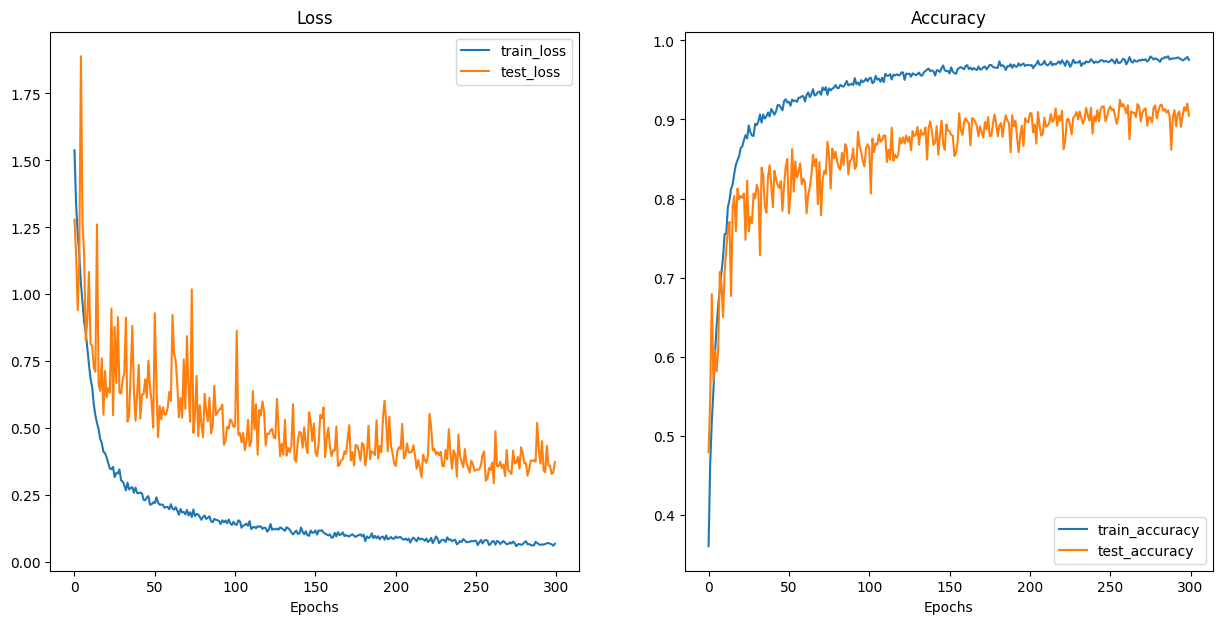

In [41]:
def plot_loss_curves(results):

    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

plot_loss_curves(model_results)

## Test the model with a random image from the internet

In [42]:
raw_img = Image.open('D:/Downloads/food101_split/test_one/pizza/pizza.jpg')
test_one_dir = Path('D:/Downloads/food101_split/test_one')

## `test_custom_images`: Predict Class of Custom Images

This function predicts the class of an image from a user-provided path.

1. **Prepares dataset and dataloader:** Creates an `ImageFolder` dataset with `test_transforms_simple` and a dataloader.
2. **Extracts sample:** Gets one image and its label, printing their shapes.
3. **Predicts in inference mode:** Iterates through batches, moves data to device, predicts labels, and retrieves class name using `data_classes`.


In [43]:
def test_custom_images(model, path):
    test_one_folder = datasets.ImageFolder(path, transform=test_transforms_simple)
    test_one_dataloader = DataLoader(test_one_folder)
    one_img, one_label = next(iter(test_one_dataloader))
    one_img.shape, one_label.shape
    with torch.inference_mode():
        # Loop through DataLoader batches
        for img, label in test_one_dataloader:
            # Send data to target device
            img, label = img.to(device),label.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(img)
            test_pred_labels = test_pred_logits.argmax(dim=1)

    print(f'The class of the test image is {data_classes[test_pred_labels.item()]}')


The class of the test image is pizza


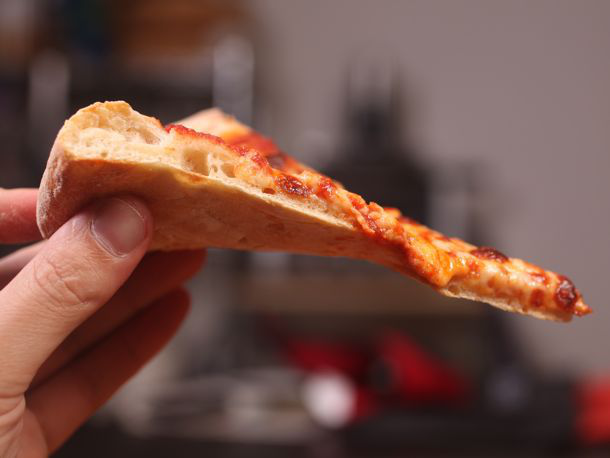

In [46]:
test_custom_images(model=model, path=test_one_dir)
raw_img

## Saving the Model

In [45]:
# path_of_model = f'D:/Downloads/food101_split/trained_model/model84.pt'
# torch.save(model.state_dict(), path_of_model)